In [1]:
from numba import float64, boolean, types, int16
from numba.experimental import jitclass
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [2]:
class Module():
    def __init__(self) -> None:
        self._runtime: float = 0.0
        self._remaining_maintenance_time: float = 0.0
        self._time_since_last_maintenance: float = 0.0
        self._under_maintenance: bool = False
        self._load: float = 0.0
        
    @property
    def Runtime(self) -> float:
        return self._runtime

    @property
    def Load(self) -> float:
        return self._load

    @Load.setter
    def Load(self, value: float) -> None:
        self._load = value

    @property
    def RemainingMaintenanceTime(self) -> float:
        return self._remaining_maintenance_time

    @RemainingMaintenanceTime.setter
    def RemainingMaintenanceTime(self, value: float) -> None:
        self._remaining_maintenance_time = value
        if self._remaining_maintenance_time <= 0:
            self._remaining_maintenance_time = 0
            self._under_maintenance = False
            self._time_since_last_maintenance = 0.0
        else:
            self._under_maintenance = True

    @property
    def TimeSinceLastMaintenance(self) -> float:
        return self._time_since_last_maintenance

    @property
    def UnderMaintenance(self) -> bool:
        return self._under_maintenance


    @property
    def Products(self) -> np.ndarray:
        return self._products

    @property
    def Consumption(self) -> np.ndarray:
        return self._consumption

    @property
    def CapeX(self) -> float:
        return 0.0

    @property
    def Opex(self) -> float:
        return 0.0


    def _check_failure(self) -> bool:
        pass

    def _produce(self) -> np.ndarray:
        pass

    def _consume(self) -> np.ndarray:
        pass

    def _maintain(self, time_delta: float):
        self.RemainingMaintenanceTime -= time_delta
        
        

    def _calculate_maintenance_time(self) -> float:
        pass

    def report_status(self) -> np.ndarray:
        status = [
            self._load,
            self._remaining_maintenance_time,
            *self._products,
            *self._consumption,
        ]
        return np.array(status)

    def update(self, time_delta: float):
        if not self._under_maintenance:
            if self._check_failure():
                self.RemainingMaintenanceTime = self._calculate_maintenance_time()
                self._maintain(time_delta)
                self._products = np.zeros_like(self._products)
                self._consumption = np.zeros_like(self._consumption)
            else:
                self._time_since_last_maintenance += time_delta
                self._runtime += time_delta
                self._products = self._produce()
                self._consumption = self._consume()
        else:
            self._maintain(time_delta)
            self._products = np.zeros_like(self._products)
            self._consumption =np.zeros_like(self._consumption)


In [3]:
@jitclass(spec=[
	('_runtime', float64),
	('_remaining_maintenance_time', float64),
	('_products', float64[:]),
	('_consumption', float64[:]),
	('_time_since_last_maintenance', float64),
	('_under_maintenance', boolean),
	('_load', float64),
	('max_el_power_uptake', float64),
	('efficiency_rules', float64[:,:]),
	('stepless_intervals', float64[:,:]),
	('h2_production_w_efficiencies', float64[:]),
	('o2_production_w_efficiencies', float64[:]),
	('o2_production_w_loads', float64[:]),
	('h2o_consumption_w_efficiencies', float64[:]),
	('maintenance_time_on_failure', float64),
	('failure_rate', float64),
	('maintenance_time_on_failure', float64)
])
class Electrolyzer(Module):
	def __init__(self, max_el_power_uptake: float, \
					efficiency_rules: np.ndarray, \
					stepless_intervals: np.ndarray, \
					failure_rate: float, \
					maintenance_time_on_failure: float):
		self.max_el_power_uptake = max_el_power_uptake
		self.efficiency_rules = efficiency_rules
		self.stepless_intervals = stepless_intervals
		# pre-calculate the o2 and h2 output for each efficiency rule
		self.h2_production_w_efficiencies = self.efficiency_rules[:, 1] * self.max_el_power_uptake / 200
		self.o2_production_w_efficiencies = self.h2_production_w_efficiencies / 2
		# pre-calculate the o2 output for each load
		self.o2_production_w_loads = np.multiply(self.efficiency_rules[:, 0], self.o2_production_w_efficiencies)
		# pre-calculate the liquid h2o consumption for each efficiency rule
		self.h2o_consumption_w_efficiencies = self.h2_production_w_efficiencies * 200
		self.failure_rate = failure_rate
		self.maintenance_time_on_failure = maintenance_time_on_failure
	

	def calculate_load(self, o2_demand: float):
		# find the index of the load rule that is closest but greater or equal (geq) than the power demand
		# first, calculate the difference between the demand and O2-Production with all load rules
		o2_demand_with_rules = self.o2_production_w_loads - o2_demand
		# check_array is setting all negative elements to np.inf. This is necessary to find the index of the smallest element
		# if all elements are negative, the power demand is greater than the maximum power output of the boiler
		# in this case, the check_array contains only np.infs. further, load needs to be 1
		check_array = np.where(o2_demand_with_rules >= 0, o2_demand_with_rules, np.inf)
		if np.all(np.isinf(check_array)):
			load = 1.0
			return load
		else:
			closest_rule_idx = np.argmin(check_array) # returns the index of the closest load in self.electrolyzer_efficiency_rules
			# check if closest_rule_idx is in a stepless interval (that means, if closest load is geq than the lower bound and leq than the upper bound of any stepless interval).
			if np.any(np.logical_and(self.electrolyzer_stepless_intervals[:, 0] <= self.electrolyzer_efficiency_rules[closest_rule_idx, 0], self.electrolyzer_efficiency_rules[closest_rule_idx, 0] <= self.electrolyzer_stepless_intervals[:, 1])):
				# now calulate the load based on power needed and efficiency, but limit maximum load to 1
				load = min(o2_demand / (self.o2_production_w_efficiencies[closest_rule_idx]), 1)
			else:
				# if not, just take the closest load
				load = self.efficiency_rules[closest_rule_idx, 0]
		return load

	def _consume(self) -> np.ndarray:
		"""
		Calculates the electricity and water consumption based on the load
		Arguments:
			load: float, electricity load as a value between 0 and 1
		Returns:
			list:
				el_consumption: float, electricity consumption in kW_el
				h2o_consumption: float, liquid water consumption in m^3/h
		"""
		closest_rule = np.argmin(np.abs(self.efficiency_rules[:, 0] - self._load))
		el_consumption = self._load * self.max_el_power_uptake
		# h2o_consumption uses the following formulas:
		# h2_production '/' h2_density_norm = h2_production_mass
		# h2_production_mass / h2_molar_weight * h2o_molar_weight = h2o_consumption_mass
		# h2o_consumption_mass / h2o_density = h2o_consumption_volume
		h2o_consumption = self._load * self.h2o_consumption_w_efficiencies[closest_rule]
		return np.array([el_consumption, h2o_consumption])

	def _produce(self) -> np.ndarray:
		"""
		calculates o2 and h2 output as well as thermal power output based on the load of the electrolyzer.
		Returns:
			list:
				o2_production: float, o2 production in Nm^3/h
				h2_production: float, h2 production in Nm^3/h
				th_power: float, thermal power output of surplus heat in kW_th
		"""
		# Find closest rule to approximate conversion efficiency at specific load
		closest_rule = np.argmin(np.abs(self.efficiency_rules[:, 0] - self._load))
		h2_power = self._load * self.efficiency_rules[closest_rule, 1] * self.max_el_power_uptake
		th_power = self._load * self.efficiency_rules[closest_rule, 2] * self.max_el_power_uptake
		h2_production = h2_power / 200

		return np.array([h2_production/2, h2_production, th_power])

	def _calculate_maintenance_time(self) -> float:
		return self.maintenance_time_on_failure
	
	def _check_failure(self) -> bool:
		# Reliability of the Module in time t for a poisson process (e ^ -(failure_rate * t))
		R = np.exp(-1 * (self.failure_rate * self.TimeSinceLastMaintenance))
		# returns true with the probability of (1 - R)
		return np.random.uniform(0, 1) > R

In [4]:
efficiency_rules = np.array([
    [0.0, 0.0, 0.0],
    [0.1, 0.4, 0.6],
    [0.2, 0.6, 0.4],
    [0.8, 0.8, 0.2],
    [1.0, 1.0, 0.0]
])

stepless_intervals = np.array([
    [0.1, 0.2],
    [0.5, 0.8]
])


In [5]:
elec = Electrolyzer(2500, efficiency_rules, stepless_intervals, (0.1) / (24 * 365), 2*24)

In [6]:
status = np.zeros((24*365 * 4 * 2, 7))
for i in range(24*365 * 4 * 2):
    elec.Load = random.uniform(0,1)
    elec.update(0.25)
    status[i] = elec.report_status()

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

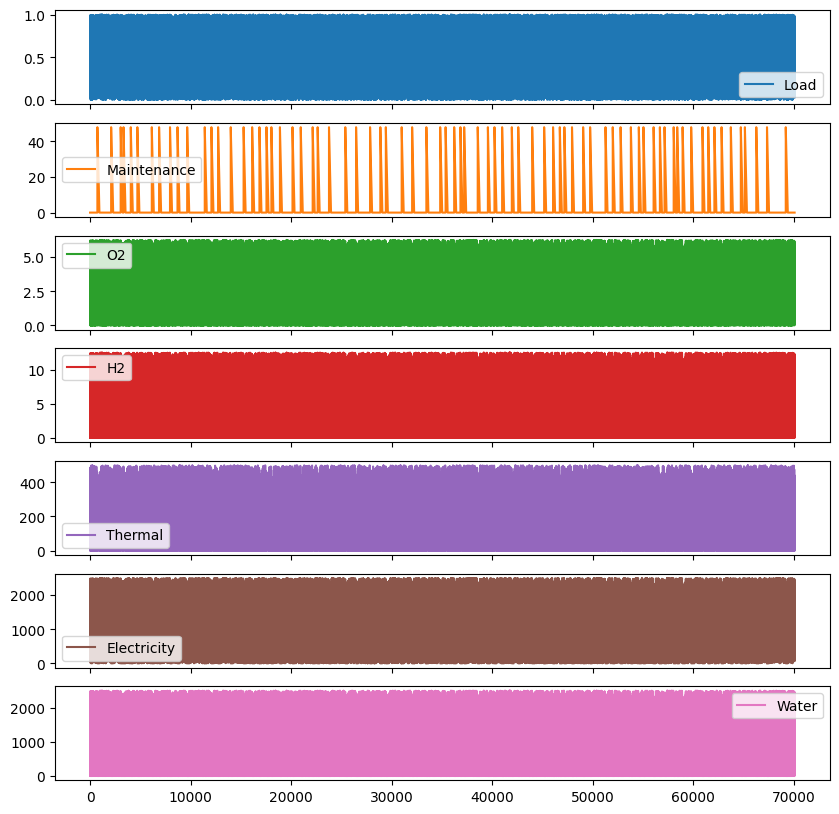

In [7]:
data = pd.DataFrame(status, columns=['Load', 'Maintenance', 'O2', 'H2', 'Thermal', 'Electricity', 'Water'])
data.plot(subplots=True, figsize=(10, 10))

In [20]:
cumsum = data['O2'][:20000].cumsum()

<AxesSubplot: >

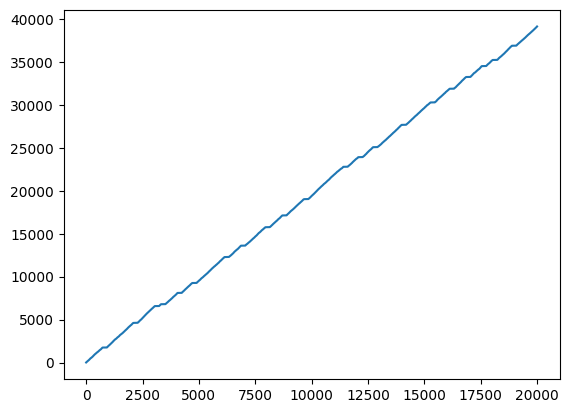

In [21]:
cumsum.plot()

In [8]:
0.5 / (24 * 365)

5.7077625570776254e-05

In [9]:
200000 * 0.25 / 24 / 365

5.707762557077626